# Pratical on $\ell_1$ minimization



## librairies
We start by importing the following librairies:


*   **cvxpy** for solving convex optimisation programs
*   **sklearn** for Machine Learning tools (OMP for instance)

In [ ]:
from __future__ import division
import time
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import cvxpy as cp

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


---

# Inverse Problem: Sparse recovery in high-dimension

----


We create an instance of a sparse linear inverse problem
$$ y = A z^\star $$
where $A$ has size dimension $N$ (*n_features*) times $d$ (*n_components*) with $N< d$. We consider a noisy version 
$$ y_{\mathrm{noisy}}= A z^\star + e$$
where $e\sim\mathcal N(0, \sigma^2\mathrm{Id})$. We use [make_coded_signal](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_sparse_coded_signal.html) from scikit-learn to generate such model.

In [ ]:
n_components, n_features = 2048, 512
n_nonzero_coefs = 64
sigma = 0.4

# generate the data
# y = Az
# |z|_0 = n_nonzero_coefs

y, A, z_star = make_sparse_coded_signal(n_samples=1,
                                   n_components=n_components,
                                   n_features=n_features,
                                   n_nonzero_coefs=n_nonzero_coefs,
                                   random_state=0)

idx, = z_star.nonzero()

# distort the clean signal
y_noisy = y + sigma * np.random.randn(len(y))

print('There is a proportion of', n_features/n_components*100, '% of features wrt components, and there is', n_nonzero_coefs/n_components*100,'% of nonzero entries wrt components')

There is a proportion of 25.0 % of features wrt components, and there is 3.125 % of nonzero entries wrt components


We can plot the target signal $z^\star$.

<StemContainer object of 3 artists>

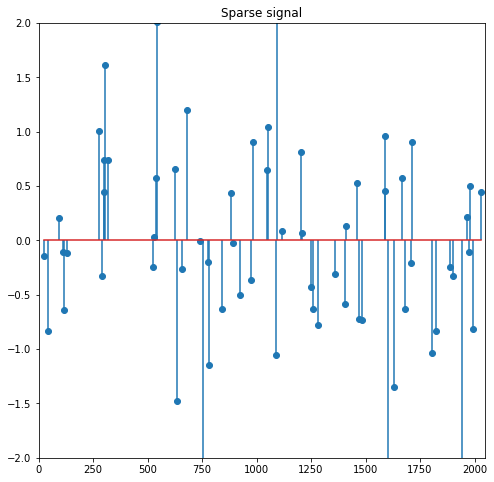

In [ ]:
# plot the sparse signal
plt.figure(figsize=(8, 8))
plt.xlim(0, n_components)
plt.ylim(-2,2)
plt.title("Sparse signal")
plt.stem(idx, z_star[idx], use_line_collection=True)

---

# Basis Pursuit

---

The reconstruction can be performed by $\ell^1$ minimization,
which regularizes the problem by exploiting the prior knowledge that the solution is sparse. 

$$\tag{$\mathcal P_1$} \min_{Az=y}\|z\|_1 $$


$$\hat z \in \arg\min_z \|{z}\|_1 \quad\mbox{s.t.}\quad Az=y$$
where the $\ell^1$ norm is defined as
$$ \|{z}\|_1 = \sum_{k=1}^d |{z_k}|. $$

This is the minimization of a non-smooth function under affine
constraints. This can be shown to be equivalent to a linear programming
problem, for wich various algorithms can be used (simplex, interior
points). 



We propose here to use three methods:

> The convex optimization solver **CVXPY** based on interior point methods.

> An implementation of the **Douglas-Rachford algorithm**. This algorithm is based on the iterations of proximal operators described below.

> **Orthogonal Matching Pursuit** which is based on the iterations 
$$\text{Add largest entry in residulas to the active support:}\quad  S^{j+1} = S^{j} \cup\{k_{j+1}\}\,,\quad k_{j+1}:=\arg\max_{k}\{|A^\top (y-A z^j)|\}$$
and
$$ \text{Fit of the solution on the active support:}\quad z^{j+1} = \arg\min_z \{\|y - Az \|_2\ :\ \mathrm{Supp}(z)\subseteq S^{j+1}\}$$

It is possible to recast this problem as the minimization of $f+g$
where $g(z) = \|{z}\|_1$ and $f(z)=\iota_{\Omega}$ where $\Omega =
\{z\ :\ {Az=y}\}$ is an affine space, and $\iota_\Omega$ is the indicator
function $ \iota_\Omega(z) =  0$ if $z \in \Omega$ and $+\infty$ otherwose.


> The proximal operator of the $\ell^1$ norm is soft thresholding:
$$ \text{prox}_{\gamma \|\cdot\|_1}(z)_k= 
\max\Big\{0, 1-\frac{\gamma}{|{z_k}|}\Big\}z_k.$$ 
A good source for proximal operators can be found at [Prox Repository](http://proximity-operator.net/index.html) website.

In [ ]:
def prox_gamma_g (z, gamma) :
    return z - z/maximum(abs(z)/gamma,1) # soft-thresholding

We can plot the soft thresholding function.

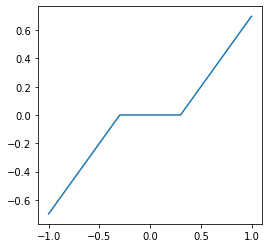

In [ ]:
figsize(4,4)
t = arange(-1,1,0.001)
plot(t, prox_gamma_g(t,0.3))

## Using CVXPY 

---

First we compute Basis Pursuit
$$\tag{$\mathcal P_1$} \min_{Az=y}\|z\|_1 $$
using **cvxpy**. 

In [ ]:
# noise-free reconstruction by L1 min

# The threshold value below which we consider an element to be zero.
delta = 1e-8

# Create variable.
z = cp.Variable(shape=n_components)

# Create constraint.
constraints = [A@z == y]

# Form objective.
obj = cp.Minimize(cp.norm(z, 1))

# Form and solve problem.
prob = cp.Problem(obj, constraints)
start_time = time.time()
prob.solve()
print("--- %s seconds ---" % (time.time() - start_time))
print("status: {}".format(prob.status))

# Number of nonzero elements in the solution (its cardinality or diversity).
nnz_l1 = (np.absolute(z.value) > delta).sum()
print('Found a feasible x in R^{} that has {} nonzeros.'.format(n_components, nnz_l1))
print("optimal objective value: {}".format(obj.value))

idx_z = np.absolute(z.value) > delta
coeff = (np.absolute(z.value) > delta)*z.value
idx_z, = idx_z.nonzero()
ampl_z = z.value[idx_z]

print('Number of errors (MP):', np.mean(idx_z!=idx), 'Norme:', np.linalg.norm(z_star-coeff))

--- 17.4259774684906 seconds ---
status: optimal
Found a feasible x in R^2048 that has 64 nonzeros.
optimal objective value: 45.930382726487466
Number of errors (MP): 0.0 Norme: 1.633219632121953e-09


We plot the solutions

Number of errors: 0.0 Norme: 1.82611980713595e-09


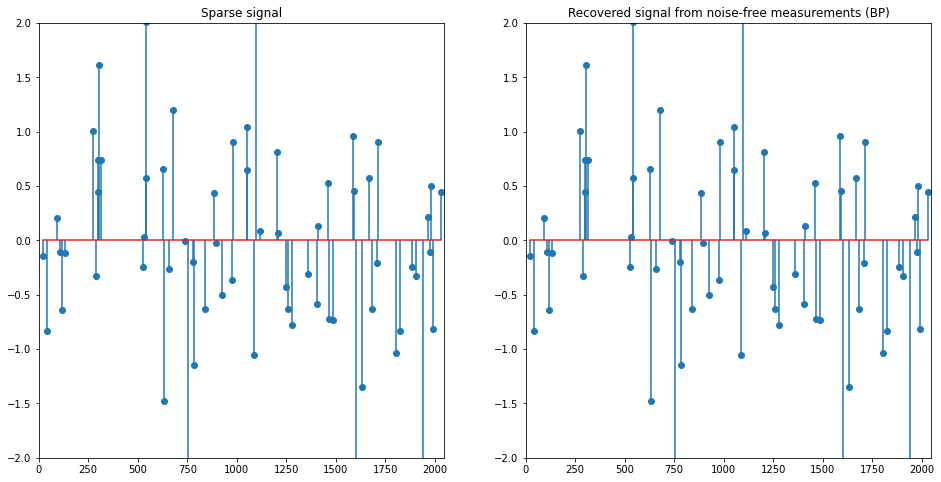

In [ ]:
# plot the sparse signal
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.ylim(-2,2)
plt.xlim(0, n_components)
plt.title("Sparse signal")
plt.stem(idx, z_star[idx], use_line_collection=True)

# noise-free reconstruction by L1 min

plt.subplot(1, 2, 2)
plt.ylim(-2,2)
plt.xlim(0, n_components)
plt.title("Recovered signal from noise-free measurements (BP)")
plt.stem(idx_z, ampl_z, use_line_collection=True)

print('Number of errors:', np.mean(idx_z!=idx), 'Norme:', np.linalg.norm(z_star-z.value))

## The Douglas-Rachford algorithm

------------------------------------

The Douglas-Rachford (DR) algorithm is an iterative scheme to minimize
functionals of the form
$$\tag{DR} \min_{x} f(x) + g(x) $$
where $f$ and $g$ are convex functions, of which one is able to
compute the proximity operators. This algorithm was introduced in

> P. L. Lions and B. Mercier
"Splitting Algorithms for the Sum of Two Nonlinear Operators,"
_SIAM Journal on Numerical Analysis_
vol. 16, no. 6, 1979,


as a generalization of an algorithm introduced by Douglas and Rachford in
the case of quadratic minimization (which corresponds to solving
a positive definite linear system). To learn more about this algorithm, you can read:

> Patrick L. Combettes and Jean-Christophe Pesquet,
"Proximal Splitting Methods in Signal Processing,"
in: _Fixed-Point Algorithms for Inverse
Problems in Science and Engineering_, New York: Springer-Verlag, 2010.

In the 1960s, Jean Jacques Moreau proposed a useful extension of the notion of projection operator to any arbitrary convex function, leading to the so-called **proximity operator**. Let $\mathcal{H}$ be a real Hilbert space (e.g., Euclidean space, space of symmetric matrices, etc.), and denote by $\Gamma_0(\mathcal{H})$ the set of lower semi-continuous convex functions 
from $\mathcal{H}$ to $\left]-\infty,+\infty\right]$.

> Let $f \in \Gamma_0(\mathcal{H})$. For every $x \in \mathcal{H}$, the minimization problem
$$
\operatorname*{minimize}_{y \in \mathcal{H}}\; f(y) + \frac{1}{2}\|x − y\|^2
$$
admits a unique solution, which is denoted by $\operatorname{prox}_f(x)$. The operator $\,\operatorname{prox}_f : \mathcal{H} \to \mathcal{H}\,$ thus defined is the proximity operator of $f$.

An important observation (left as an exercice) is the following:

> If $x$ is a solution to (DR) then 
$$x = \mathrm{prox}_{\gamma f} (s) $$
for some $s$ satisfying
$$ \mathrm{prox}_{\gamma f} (s) = \text{prox}_{\gamma g}( 2\mathrm{prox}_{\gamma f} (s)-s)$$
for any tunning paramter $\gamma >0$.

The Douglas-Rachford algorithm takes an arbitrary element $s^{(0)}$, a parameter $\gamma>0$, a relaxation parameter $0<\rho < 2$ and iterates, for $k=1,2,\ldots$

$$
\left|\begin{array}{l}
x^{(k)} = \mathrm{prox}_{\gamma f} (s^{(k-1)} )\\
s^{(k)} = s^{(k-1)}+\rho\big(\text{prox}_{\gamma g}( 2x^{(k)}-s^{(k-1)})-x^{(k)}\big).
\end{array}\right.
$$

It is of course possible to inter-change the roles of $f$ and $g$,
which defines a different algorithm. The iterates $x^{(k)}$ converge to a solution $x^\star$ of the problem, i.e. a minimizer of $f+g$.

In [ ]:
pA = pinv(A) # pseudo-inverse. Equivalent to pA = A.T.dot(inv(A.dot(A.T)))
def prox_f (x, y) :
    return x + pA.dot(y-A.dot(x))

We set some hyper-parameters

In [ ]:
gamma = 0.1 # try 1, 10, 0.1
rho = 1     # try 1, 1.5, 1.9

We set the number of iterations

In [ ]:
nbiter = 1000

Here the DR code:

In [ ]:
s = zeros(n_components)
En_array = zeros(nbiter)
start_time = time.time()
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    x = prox_f(s,y)
    s += rho*(prox_gamma_g(2*x-s, gamma)-x)
    En_array[iter] = norm(x, ord=1)  
x_restored = x
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.889704942703247 seconds ---


We plot the solutions

Text(0.5, 1.0, '$\\hat{z}$')

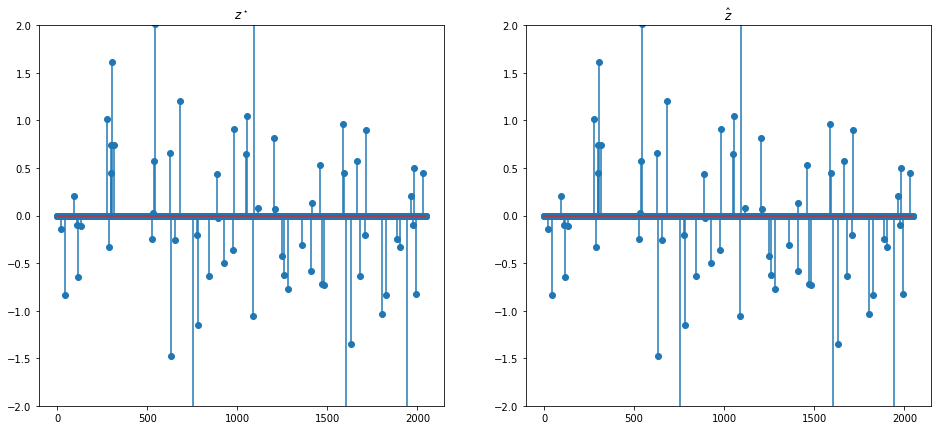

In [ ]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(z_star)
subfig1.set_ylim(-2,2)
subfig2.stem(x_restored)
subfig2.set_ylim(-2,2)
subfig1.set_title('$z^\star$')
subfig2.set_title('$\hat{z}$')

We plot the error wrt the number of iterations

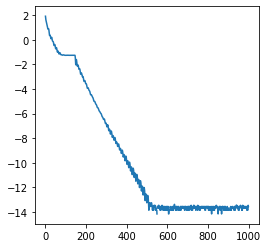

In [ ]:
plot(log10(En_array-En_array.min()))

## Orthogonal Matching Pursuit (OMP)

---

We solve it using **scikit-learn** librairy with:

> omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs) where *n_nonzero_coefs* is the stopping criterion (number of atoms in the active support). In practice we choose this hyperparamter using cross validation (CV).

> omp.fit(A, y) that fits the OMP on the data.

--- 0.06596779823303223 seconds ---
Number of errors (OMP): 0.0 Norme: 3.023957186975778e-15


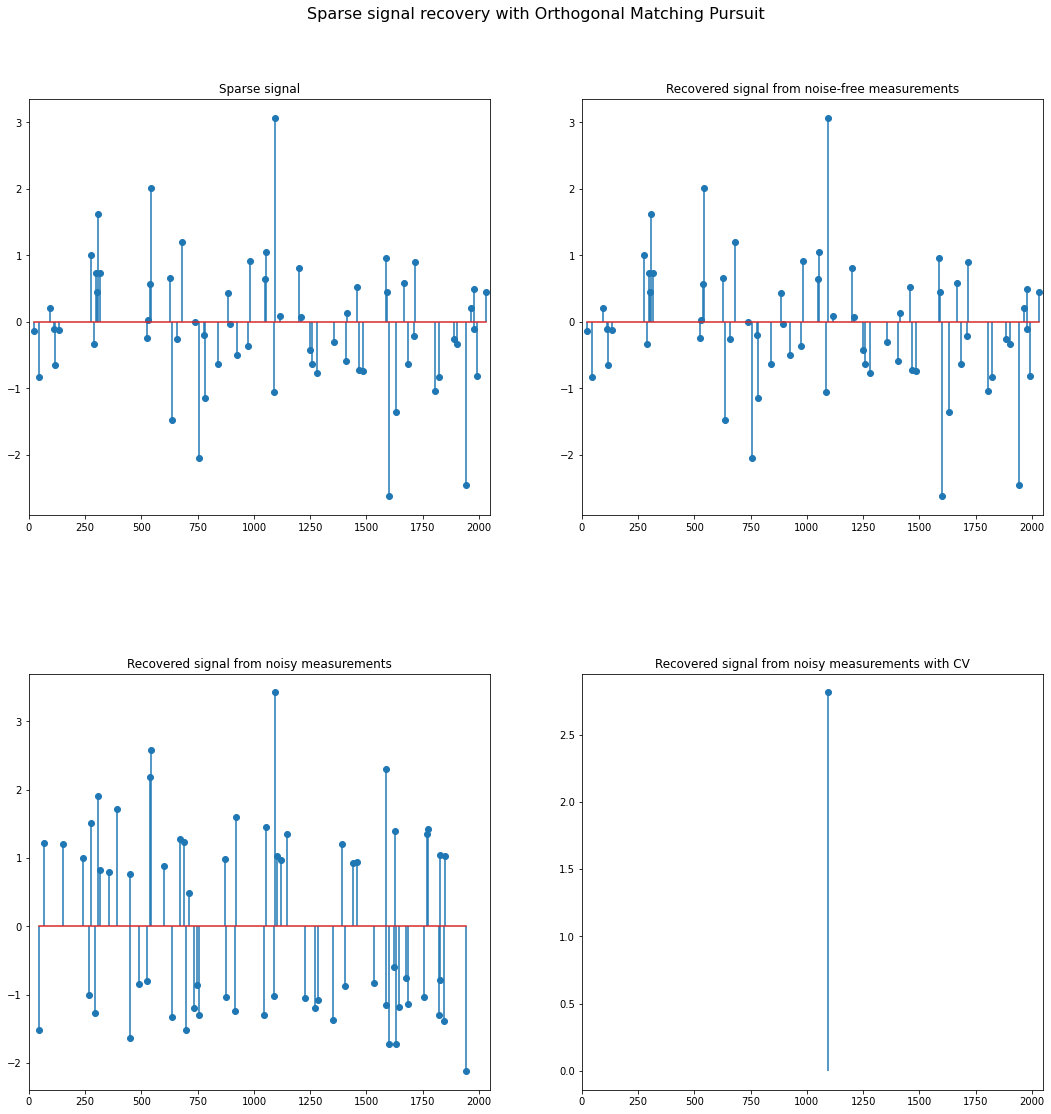

In [ ]:
# plot the sparse signal
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.xlim(0, n_components)
plt.title("Sparse signal")
plt.stem(idx, z_star[idx], use_line_collection=True)

# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
start_time = time.time()
omp.fit(A, y)
print("--- %s seconds ---" % (time.time() - start_time))
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(2, 2, 2)
plt.xlim(0, n_components)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

print('Number of errors (OMP):', np.mean(idx_r!=idx), 'Norme:', np.linalg.norm(z_star-coef))

# plot the noisy reconstruction
omp.fit(A, y_noisy)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(2, 2, 3)
plt.xlim(0, n_components)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV()
omp_cv.fit(A, y_noisy)
coef = omp_cv.coef_
idx_r, = coef.nonzero()
plt.subplot(2, 2, 4)
plt.xlim(0, n_components)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle('Sparse signal recovery with Orthogonal Matching Pursuit',
             fontsize=16)
plt.show()

---

# LASSO

---

We consider a linear inverse problem
$$ y = A z^\star + e  \in \mathbb R^N$$
where $z^\star \in \mathbb R^d$ is the (unknown) signal to recover, $e \in
\mathbb R^N$ is a noise vector, and $A \in \mathbb R^{N \times d}$ models the
acquisition device.


> To recover an estimate of the signal $z^\star$, we consider  basis
pursuit denoising, which makes use of the $\ell^1$ norm as sparsity
enforcing penalty:
$$ \min_{x \in \mathbb R^d} \frac{1}{2} \|{A x-y}\|^2 + \lambda \|{x}\|_1, $$
The parameter $\lambda>0$ should be set in accordance to the noise level
$\|{w}\|$.


## Forward-Bacward splitting

---

This minimization problem can be cast in the form of minimizing $f+g$
where
$$ f(x) = \frac{1}{2} \|{Ax-y}\|^2
\quad g(x) = \lambda \|{x}\|_1. $$


$f$ is smooth; we have
$$ \nabla f(x) = A^* (A x - y),  $$
which is $\beta$-Lipschitz continuous, with
$$ \beta = \|{ A^\top A }\|. $$


The $\ell^1$-norm is "simple", because its proximal operator is soft
thresholding:
$$ \big(\text{prox}_{\gamma g}(x)\big)_n = \max\big\{ 0, 1 - \frac{\lambda \gamma}{|{x_n}|} \big\} x_n. $$

We define the proximity operator of $\gamma g$.

In [ ]:
def prox_gamma_g (x, gamma, Lambda) :
    return x - x/maximum(abs(x)/(Lambda*gamma),1) # soft-thresholding

We define the gradient operator of $f$.

In [ ]:
grad_f = lambda x : A.transpose() @(A@x-y_noisy)

Hyper-parameters

In [ ]:
Lambda = 0.9
gamma = 0.1 # try 1, 10, 0.1
rho = 1.5     # try 1, 1.5, 1.9

The FB splitting method:

In [ ]:
nbiter = 1000
x = zeros(n_components)
En_array = zeros(nbiter+1)
En_array[0] = norm(A@(x) - y_noisy)**2/2 + Lambda*norm(x, ord=1)
start_time = time.time()
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    x = prox_gamma_g(x - gamma*grad_f(x), gamma, Lambda)
    En_array[iter+1] = norm(A@x - y_noisy)**2/2 + Lambda*norm(x, ord=1)  
x_restored = x
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.2138876914978027 seconds ---


We plot the solutions

Text(0.5, 1.0, '$\\hat{z}$')

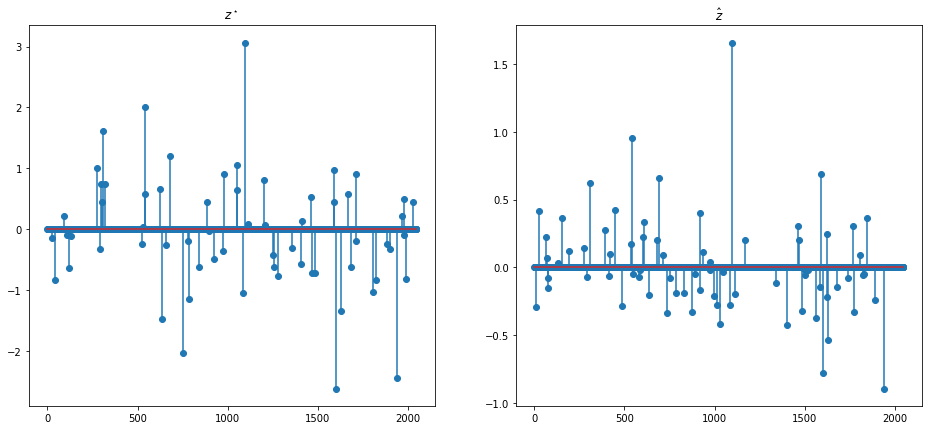

In [ ]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(z_star)
subfig2.stem(x_restored)
subfig1.set_title('$z^\star$')
subfig2.set_title('$\hat{z}$')

We plot the relative error $(E_k-E^\star)/(E_0-E^\star)$ in log-scale with respect to $k$.

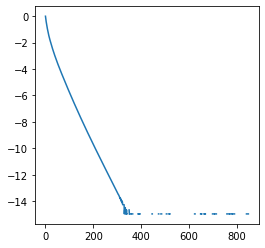

In [ ]:
plot(log10((En_array[0:nbiter]-En_array[-1])/(En_array[0]-En_array[-1])))

## FISTA-like Accelerated Forward-Backward Algorithm

------

We consider the FISTA algorithm introduced in:

> A. Beck and M. Teboulle,
"A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems",
_SIAM Journal on Imaging Sciences_, 2009.

More precisely, we consider a slightly modified version of FISTA, whose convergence is proved, see
A. Chambolle and C. Dossal, "On the convergence of the iterates of "FISTA"", preprint, 2015.

Given an initial estimate $x^{(0)}$ of the solution and a parameter $a>2$, the algorithm sets $\gamma>0$, sets $z^{(0)}=x^{(0)} \in \mathbb R^d$,
and iterates, for $k=1,2,\ldots$
$$ x^{(k)} = \text{prox}_{\gamma g}\{
              z^{(k-1)} - \gamma \nabla f( z^{(k-1)} )  \}.
$$
$$ \alpha_k=(k-1)/(k+a) $$
$$ z^{(k)} = x^{(k)} +
      \alpha_k
  \{ x^{(k)} - x^{(k-1)} \} $$


It is proved that the iterates $x^{(k)}$ converge to a solution $x^\star$ of the problem. Moreover, 
the  optimal convergence rate for this class of problems is reached,
namely
$$ E_k - E^\star = O(1/k^2), $$
whereas the convergence rate for the normal forward-backward is only
$O(1/k)$.

Note the difference between the over-relaxed forward-backward and the accelerated forward-backward: the later is based on an inertia mechanism, of different nature than over-relaxation.

In [ ]:
nbiter = 500
a = 10
x = zeros(n_components)
En_array_fista = zeros(nbiter+1)
En_array_fista[0] = norm(A@x - y_noisy)**2/2 + Lambda*norm(x, ord=1)
z = x
start_time = time.time()
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    xprevious = x
    x = prox_gamma_g(z - gamma*grad_f(z), gamma, Lambda)
    alpha = iter/(iter+1+a)
    z = x + alpha * (x - xprevious)
    En_array_fista[iter+1] = norm(A@x - y_noisy)**2/2 + Lambda*norm(x, ord=1)  
x_restored = x
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5961246490478516 seconds ---


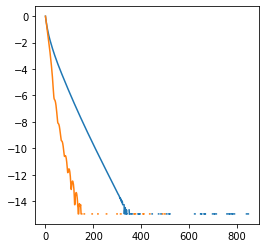

In [ ]:
plot(log10((En_array[0:1800]-En_array[-1])/(En_array[0]-En_array[-1])))
plot(log10((En_array_fista[0:1800]-En_array[-1])/(En_array[0]-En_array[-1])))

## CVXPY

A nice presentation on how to solve LASSO with CVXPY can be found at [CVXPY example on Lasso Regression ](https://www.cvxpy.org/examples/machine_learning/lasso_regression.html). We reproduce here the main features. 

In [ ]:
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return (1/2)*loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

In [ ]:
# The threshold value below which we consider an element to be zero.
delta = 1e-8

# Create variable.
z = cp.Variable(shape=n_components)

# Form objective.
obj = cp.Minimize(objective_fn(A, y_noisy, z, Lambda))

# Form and solve problem.
prob = cp.Problem(obj)

start_time = time.time()
prob.solve()
print("--- %s seconds ---" % (time.time() - start_time))
print("status: {}".format(prob.status))

# Number of nonzero elements in the solution (its cardinality or diversity).
nnz_l1 = (np.abs(z.value) > delta).sum()
print('Found a feasible x in R^{} that has {} nonzeros.'.format(n_components, nnz_l1))
print("optimal objective value: {}".format(obj.value))

idx_z = np.absolute(z.value) > delta
coeff = (np.absolute(z.value) > delta)*z.value
idx_z, = idx_z.nonzero()
ampl_z = z.value[idx_z]

print('Number of errors (MP):', np.mean(idx_z!=idx), 'Norme:', np.linalg.norm(z_star-coeff))

--- 17.791860580444336 seconds ---
status: optimal
Found a feasible x in R^2048 that has 75 nonzeros.
optimal objective value: 59.92202920795776
Number of errors (MP): 1.0 Norme: 6.116146420509076


Number of errors: 1.0 Norme: 6.116146419207074


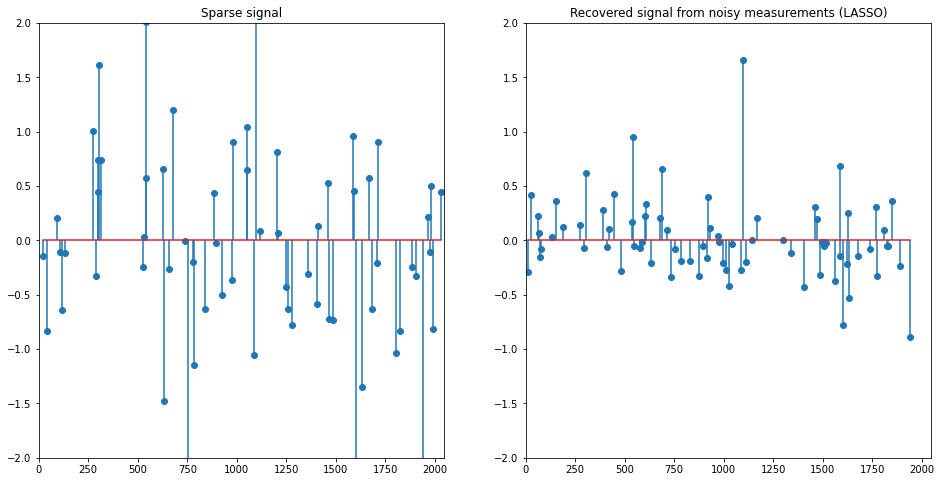

In [ ]:
# plot the sparse signal
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.ylim(-2,2)
plt.xlim(0, n_components)
plt.title("Sparse signal")
plt.stem(idx, z_star[idx], use_line_collection=True)

# reconstruction by LASSO

plt.subplot(1, 2, 2)
plt.ylim(-2,2)
plt.xlim(0, n_components)
plt.title("Recovered signal from noisy measurements (LASSO)")
plt.stem(idx_z, ampl_z, use_line_collection=True)

print('Number of errors:', np.mean(idx_z!=idx), 'Norme:', np.linalg.norm(z_star-z.value))

CV

In [ ]:
X_train = A[:50, :]
Y_train = y_noisy[:50]
X_test = A[50:, :]
Y_test = y_noisy[50:]

In [ ]:
beta = cp.Variable(n_components)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-3, 0.1, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

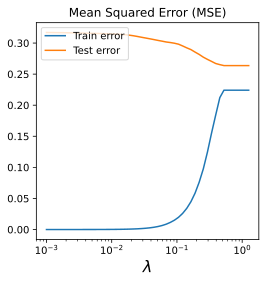

In [ ]:
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

plot_train_test_errors(train_errors, test_errors, lambd_values)

In [ ]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, beta_values)